# Geez Character Recognition With CapsNet

### Importing Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
plt.rcParams['font.family'] = 'Abyssinica SIL' 

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


### Loading and Preprocessing Data


In [2]:
# Custom Dataset for Amharic characters
class AmharicDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the character folders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transforms - resize to same size as MNIST
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

# Load Amharic dataset
dataset_path = "/home/hailemicaelyimer/Desktop/ACR/dataset"
full_dataset = AmharicDataset(root_dir=dataset_path, transform=transform)

# Split dataset
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
valid_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display some sample images
def display_sample_images(n_samples=5):
    plt.figure(figsize=(n_samples * 2, 3))
    
    # Get random samples
    indices = random.sample(range(len(full_dataset)), n_samples)
    
    for i, idx in enumerate(indices):
        image, label = full_dataset[idx]
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(image.squeeze().numpy(), cmap="binary")
        plt.title(f"Label: {full_dataset.classes[label]}")
        plt.axis("off")
    
    plt.show()

# Parameters for primary capsules
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

# Parameters for character capsules
caps2_n_caps = len(full_dataset.classes)  # Number of Amharic character classes
caps2_n_dims = 16

print(f"Number of Amharic character classes: {caps2_n_caps}")
print(f"Total dataset size: {dataset_size} (Train: {train_size}, Val: {valid_size}, Test: {test_size})")


Number of Amharic character classes: 142
Total dataset size: 22761 (Train: 18208, Val: 2276, Test: 2277)


### Model Architecture


In [3]:
# Squash function
def squash(s, axis=-1, epsilon=1e-7):
    squared_norm = torch.sum(s**2, dim=axis, keepdim=True)
    safe_norm = torch.sqrt(squared_norm + epsilon)
    squash_factor = squared_norm / (1.0 + squared_norm)
    unit_vector = s / safe_norm
    return squash_factor * unit_vector

# Safe norm function
def safe_norm(s, axis=-1, epsilon=1e-7, keepdim=False):
    squared_norm = torch.sum(s**2, dim=axis, keepdim=keepdim)
    return torch.sqrt(squared_norm + epsilon)

# Create the model
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=9,
            stride=1,
            padding=0
        )
        
        # Second convolutional layer (for primary capsules)
        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=caps1_n_maps * caps1_n_dims,  # 256 = 32 * 8
            kernel_size=9,
            stride=2,
            padding=0
        )
        
        # Transformation matrices
        self.W = nn.Parameter(
            torch.randn(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims) * 0.1
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(caps2_n_dims * caps2_n_caps, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x, y=None, mask_with_labels=False):
        batch_size = x.size(0)
        
        # First convolutional layer with ReLU activation
        x = F.relu(self.conv1(x))
        
        # Second convolutional layer with ReLU activation
        x = F.relu(self.conv2(x))
        
        # Reshape to get primary capsules output
        caps1_raw = x.view(batch_size, caps1_n_caps, caps1_n_dims)
        
        # Apply squash to get output of primary capsules
        caps1_output = squash(caps1_raw)
        
        # Prepare data for computing the predicted vectors
        W_tiled = self.W.repeat(batch_size, 1, 1, 1, 1)
        
        # Expand dimensions of caps1_output for matrix multiplication
        caps1_output_expanded = caps1_output.unsqueeze(-1)
        caps1_output_tile = caps1_output_expanded.unsqueeze(2)
        caps1_output_tiled = caps1_output_tile.repeat(1, 1, caps2_n_caps, 1, 1)
        
        # Calculate predicted output vectors
        caps2_predicted = torch.matmul(W_tiled, caps1_output_tiled)
        
        # Initialize routing weights
        raw_weights = torch.zeros(batch_size, caps1_n_caps, caps2_n_caps, 1, 1, device=x.device)
        
        # Routing by agreement algorithm - Round 1
        routing_weights = F.softmax(raw_weights, dim=2)
        weighted_predictions = routing_weights * caps2_predicted
        weighted_sum = weighted_predictions.sum(dim=1, keepdim=True)
        caps2_output_round_1 = squash(weighted_sum, axis=-2)
        
        # Routing by agreement algorithm - Round 2
        caps2_output_round_1_tiled = caps2_output_round_1.repeat(1, caps1_n_caps, 1, 1, 1)
        agreement = torch.matmul(
            torch.transpose(caps2_predicted, -1, -2),
            caps2_output_round_1_tiled
        )
        
        raw_weights_round_2 = raw_weights + agreement
        routing_weights_round_2 = F.softmax(raw_weights_round_2, dim=2)
        weighted_predictions_round_2 = routing_weights_round_2 * caps2_predicted
        weighted_sum_round_2 = weighted_predictions_round_2.sum(dim=1, keepdim=True)
        caps2_output = squash(weighted_sum_round_2, axis=-2)
        
        # Calculate class probabilities (length of output vectors)
        y_proba = safe_norm(caps2_output, axis=-2)
        y_proba = y_proba.squeeze()
        
        # Class prediction
        _, y_pred = y_proba.max(dim=1)
        
        # Masking mechanism
        if y is not None:
            if mask_with_labels:
                # Use true labels for reconstruction
                reconstruction_targets = y
            else:
                # Use predicted labels for reconstruction
                reconstruction_targets = y_pred
                
            # Create mask
            reconstruction_mask = torch.zeros(batch_size, caps2_n_caps, device=x.device)
            reconstruction_mask.scatter_(1, reconstruction_targets.view(-1, 1), 1.)
            
            # Reshape mask for multiplication
            reconstruction_mask_reshaped = reconstruction_mask.view(batch_size, 1, caps2_n_caps, 1, 1)
            
            # Apply mask to the output vectors
            caps2_output_masked = caps2_output * reconstruction_mask_reshaped
            
            # Flatten decoder input
            decoder_input = caps2_output_masked.view(batch_size, -1)
            
            # Generate reconstructions
            reconstructions = self.decoder(decoder_input)
        else:
            reconstructions = None
        
        return caps2_output, y_proba, y_pred, reconstructions

# Margin loss
def margin_loss(y_true, y_proba, m_plus=0.9, m_minus=0.1, lambda_=0.5):
    batch_size = y_true.size(0)
    
    # Convert labels to one-hot vectors
    y_one_hot = torch.zeros(batch_size, caps2_n_caps, device=y_true.device)
    y_one_hot.scatter_(1, y_true.view(-1, 1), 1.)
    
    # Calculate present character loss
    present_error = torch.max(torch.zeros_like(y_proba), m_plus - y_proba)**2
    
    # Calculate absent character loss
    absent_error = torch.max(torch.zeros_like(y_proba), y_proba - m_minus)**2
    
    # Combine losses
    L = y_one_hot * present_error + lambda_ * (1 - y_one_hot) * absent_error
    
    # Sum over all character capsules and calculate mean over batch
    margin_loss = L.sum(dim=1).mean()
    
    return margin_loss

# Create the model
model = CapsNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Optimizer
optimizer = torch.optim.Adam(model.parameters())

Using device: cuda


### Training


Number of Amharic character classes: 147
Total dataset size: 22761 (Train: 18208, Val: 2276, Test: 2277)
Using device: cuda


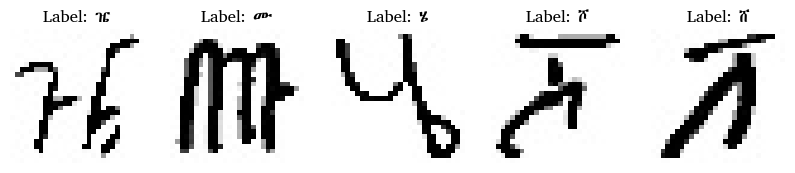

Iteration: 0/365 (0.0%) Loss: 0.80952
Iteration: 10/365 (2.7%) Loss: 0.71745
Iteration: 20/365 (5.5%) Loss: 0.65406
Iteration: 30/365 (8.2%) Loss: 0.62371
Iteration: 40/365 (11.0%) Loss: 0.60383
Iteration: 50/365 (13.7%) Loss: 0.60117
Iteration: 60/365 (16.4%) Loss: 0.57409
Iteration: 70/365 (19.2%) Loss: 0.57595
Iteration: 80/365 (21.9%) Loss: 0.58031
Iteration: 90/365 (24.7%) Loss: 0.54406
Iteration: 100/365 (27.4%) Loss: 0.52723
Iteration: 110/365 (30.1%) Loss: 0.50899
Iteration: 120/365 (32.9%) Loss: 0.52378
Iteration: 130/365 (35.6%) Loss: 0.51689
Iteration: 140/365 (38.4%) Loss: 0.49580
Iteration: 150/365 (41.1%) Loss: 0.50852
Iteration: 160/365 (43.8%) Loss: 0.45668
Iteration: 170/365 (46.6%) Loss: 0.46697
Iteration: 180/365 (49.3%) Loss: 0.48308
Iteration: 190/365 (52.1%) Loss: 0.47814
Iteration: 200/365 (54.8%) Loss: 0.45139
Iteration: 210/365 (57.5%) Loss: 0.41735
Iteration: 220/365 (60.3%) Loss: 0.46234
Iteration: 230/365 (63.0%) Loss: 0.43251
Iteration: 240/365 (65.8%) Loss

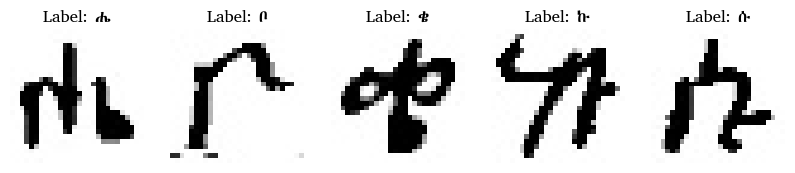

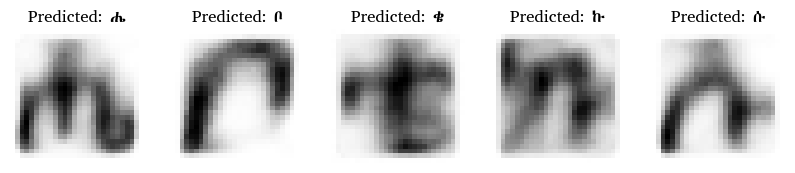

Tweaking output dimension #0


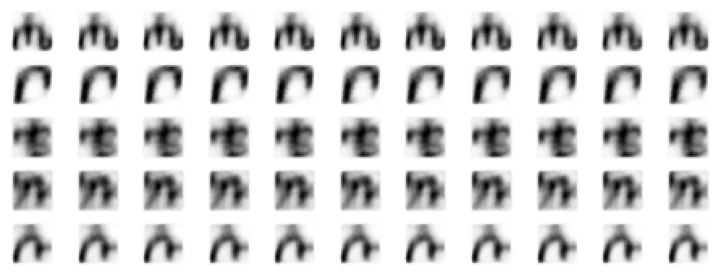

Tweaking output dimension #1


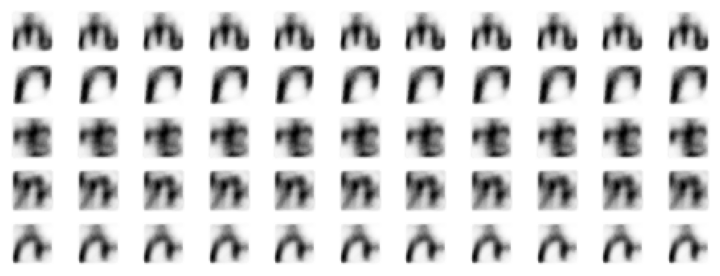

Tweaking output dimension #2


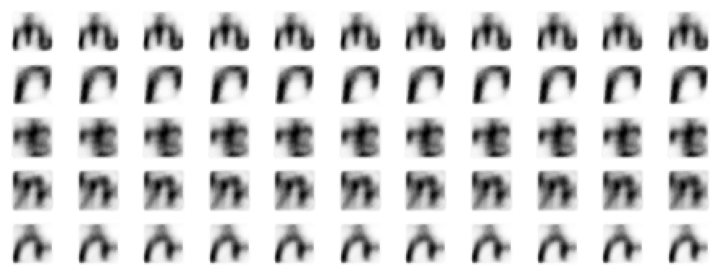

: 

In [ ]:
# Training function
def train(model, device, train_loader, optimizer, epoch, alpha=0.0005):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        caps2_output, y_proba, y_pred, reconstructions = model(data, target, mask_with_labels=True)
        
        # Calculate margin loss
        m_loss = margin_loss(target, y_proba)
        
        # Calculate reconstruction loss
        reconstruction_loss = F.mse_loss(reconstructions, data.view(-1, 784))
        
        # Combined loss
        loss = m_loss + alpha * reconstruction_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        correct += (y_pred == target).sum().item()
        total += target.size(0)
        
        # Print progress
        if batch_idx % 10 == 0:
            print(f'Iteration: {batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.1f}%) Loss: {loss.item():.5f}')
    
    # Return epoch statistics
    return total_loss / len(train_loader), 100. * correct / total

# Validation/Test function
def evaluate(model, device, data_loader, alpha=0.0005):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            
            # Forward pass
            caps2_output, y_proba, y_pred, reconstructions = model(data, target, mask_with_labels=False)
            
            # Calculate margin loss
            m_loss = margin_loss(target, y_proba)
            
            # Calculate reconstruction loss
            reconstruction_loss = F.mse_loss(reconstructions, data.view(-1, 784))
            
            # Combined loss
            batch_loss = m_loss + alpha * reconstruction_loss
            
            # Statistics
            loss += batch_loss.item()
            correct += (y_pred == target).sum().item()
            total += target.size(0)
            
            # Print progress
            if batch_idx % 5 == 0:
                print(f'Evaluating: {batch_idx}/{len(data_loader)} ({100. * batch_idx / len(data_loader):.1f}%)', end='\r')
    
    # Return evaluation statistics
    return loss / len(data_loader), 100. * correct / total

# Visualization of reconstructions
def visualize_reconstructions(model, device, test_loader, n_samples=5):
    model.eval()
    
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    sample_images = images[:n_samples].to(device)
    sample_labels = labels[:n_samples].to(device)
    
    with torch.no_grad():
        caps2_output, _, y_pred, reconstructions = model(sample_images, sample_labels, mask_with_labels=False)
    
    # Get original class names
    original_labels = [full_dataset.classes[label.item()] for label in sample_labels]
    predicted_labels = [full_dataset.classes[pred.item()] for pred in y_pred]
    
    # Plot original images
    plt.figure(figsize=(n_samples * 2, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(sample_images[i].cpu().squeeze().numpy(), cmap="binary")
        plt.title(f"Label: {original_labels[i]}")
        plt.axis("off")
    plt.show()
    
    # Plot reconstructions
    plt.figure(figsize=(n_samples * 2, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(reconstructions[i].cpu().view(28, 28).numpy(), cmap="binary")
        plt.title(f"Predicted: {predicted_labels[i]}")
        plt.axis("off")
    plt.show()

# Function to visualize tweaked parameters
def visualize_tweaked_parameters(model, device, test_loader, min_val=-0.5, max_val=0.5, n_steps=11, n_samples=5, n_dims=3):
    model.eval()
    
    # Get sample images and labels
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    sample_images = images[:n_samples].to(device)
    sample_labels = labels[:n_samples].to(device)
    
    with torch.no_grad():
        # Get the original capsule outputs
        caps2_output, _, _, _ = model(sample_images, sample_labels, mask_with_labels=False)
        
        # Create tweaked versions
        steps = torch.linspace(min_val, max_val, n_steps, device=device)
        
        for dim in range(n_dims):
            print(f"Tweaking output dimension #{dim}")
            reconstructions = []
            
            for step in steps:
                # Clone the output and modify one dimension
                tweaked_output = caps2_output.clone()
                tweaked_output[:, :, :, dim, :] += step
                
                # Create mask for reconstruction
                reconstruction_mask = torch.zeros(sample_images.size(0), caps2_n_caps, device=device)
                reconstruction_mask.scatter_(1, sample_labels.view(-1, 1), 1.)
                reconstruction_mask_reshaped = reconstruction_mask.view(sample_images.size(0), 1, caps2_n_caps, 1, 1)
                
                # Apply mask and get reconstruction
                masked_output = tweaked_output * reconstruction_mask_reshaped
                decoder_input = masked_output.view(sample_images.size(0), -1)
                recon = model.decoder(decoder_input)
                reconstructions.append(recon.view(-1, 28, 28))
            
            # Plot reconstructions
            plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
            for row in range(n_samples):
                for col in range(n_steps):
                    plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
                    plt.imshow(reconstructions[col][row].cpu().numpy(), cmap="binary")
                    plt.axis("off")
            plt.show()

# Training loop
def main():
    # Display sample images
    display_sample_images()
    
    n_epochs = 30  # You may need more epochs for Amharic characters
    best_val_loss = float('inf')
    
    for epoch in range(1, n_epochs + 1):
        # Train
        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
        
        # Validate
        val_loss, val_acc = evaluate(model, device, valid_loader)
        
        # Print results
        print(f"Epoch: {epoch}  Val accuracy: {val_acc:.4f}%  Loss: {val_loss:.6f}" +
              (" (improved)" if val_loss < best_val_loss else ""))
        
        # Save model if improved
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), "capsnet_amharic_best.pth")
            best_val_loss = val_loss
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load("capsnet_amharic_best.pth"))
    test_loss, test_acc = evaluate(model, device, test_loader)
    print(f"Final test accuracy: {test_acc:.4f}%  Loss: {test_loss:.6f}")
    
    # Visualize reconstructions
    visualize_reconstructions(model, device, test_loader)
    
    # Visualize tweaked parameters
    visualize_tweaked_parameters(model, device, test_loader)

if __name__ == "__main__":
    main()